In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Importing the required libraries
import os
import random
import csv
import pydicom
import numpy as np
from skimage.transform import resize
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
#Declaring an empty dictionary to populate with the location corresponding to each patient ID if TARGET =1  
pneumonia_locations = {}
with open(os.path.join('/content/drive/MyDrive/Capstone/stage_2_train_labels.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
      filename = rows[0]
      location = rows[1:5]
      pneumonia = rows[5]
      if pneumonia == '1':
        location = [int(float(i)) for i in location]
        if filename in pneumonia_locations:
          pneumonia_locations[filename].append(location)
        else:
          pneumonia_locations[filename] = [location]

In [ ]:
class generator_single_channel(keras.utils.Sequence):
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, predict=False):
      self.folder = folder
      self.filenames = filenames
      self.pneumonia_locations = pneumonia_locations
      self.batch_size = batch_size
      self.image_size = image_size
      self.shuffle = shuffle
      self.predict = predict
      self.on_epoch_end()

    def __load__(self, filename):
      img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
      msk = np.zeros(img.shape)
      filename = filename.split('.')[0]
      is_pneumonia = int(0)
      if filename in self.pneumonia_locations:
        is_pneumonia = int(1)
        for location in self.pneumonia_locations[filename]:
          x, y, w, h = location
          msk[y:y+h, x:x+w] = 1

      img = resize(img, (self.image_size, self.image_size), mode='reflect')
      msk = resize(msk, (self.image_size, self.image_size), mode='reflect')

      img = np.expand_dims(img, axis=-1)
      msk = np.expand_dims(msk, axis=-1)
      is_pneumonia = np.array(is_pneumonia)

      return img, msk

    def __loadpredict__(self, filename):
      img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
      img = resize(img, (self.image_size, self.image_size), mode='reflect')
      img = np.expand_dims(img, axis=-1)

      return img

    def __getitem__(self, index):
      filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
      if self.predict:
        imgs = [self.__loadpredict__(filename) for filename in filenames]
        imgs = np.array(imgs)

        return imgs,filenames

      else:
        items = [self.__load__(filename) for filename in filenames]
        imgs, msks = zip(*items)
        imgs = np.array(imgs)
        msks = np.array(msks)

        return imgs,msks

    def on_epoch_end(self):
      if self.shuffle:
        random.shuffle(self.filenames)

    def __len__(self):
      if self.predict:
        return int(np.ceil(len(self.filenames) / self.batch_size))
      else:
        return int(len(self.filenames) / self.batch_size)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
  #First Layer
  x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(input_tensor)
  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation("relu")(x)
  #Second Layer
  x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(x)
  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((224, 224, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

In [ ]:
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
model.compile(optimizer='adam', loss=iou_loss, metrics=[mean_iou,'accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("pnuemonia-detection-unet_{val_loss:.4f}.h5",monitor='val_loss', verbose=1, save_best_only=False,save_weights_only=True, mode="auto")
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
folder = '/content/drive/MyDrive/Capstone/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)

In [ ]:
img = pydicom.dcmread(os.path.join(folder, filenames[2])).pixel_array

In [ ]:
train_filenames = filenames[6000:]
valid_filenames = filenames[:6000]
print('Number of train samples', len(train_filenames))
print('Number of validation samples', len(valid_filenames))

Number of train samples 20684
Number of validation samples 6000


In [ ]:
train_gen_simple = generator_single_channel(folder, train_filenames, pneumonia_locations, batch_size=64, image_size=224, shuffle=True, predict=False)
valid_gen_simple= generator_single_channel(folder, valid_filenames, pneumonia_locations, batch_size=64, image_size=224, shuffle=False, predict=False)

In [ ]:
#history = model.fit(train_gen_simple, validation_data=valid_gen_simple, callbacks=[checkpoint,es], epochs=1)

323/323 [==============================] - ETA: 0s - loss: 0.8457 - mean_iou: 0.1969 - accuracy: 0.9096 
Epoch 00001: saving model to pnuemonia-detection-unet_0.9481.h5
323/323 [==============================] - 17693s 55s/step - loss: 0.8457 - mean_iou: 0.1969 - accuracy: 0.9096 - val_loss: 0.9481 - val_mean_iou: 0.0524 - val_accuracy: 0.6928


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage
import matplotlib as mpl
import cv2

NameError: ignored

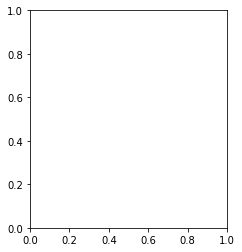

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/GL Capstone - Pneumonia/pnuemonia-detection-unet_0.8515.h5')

In [ ]:
from skimage import measure
import matplotlib.patches as patches

IndexError: ignored

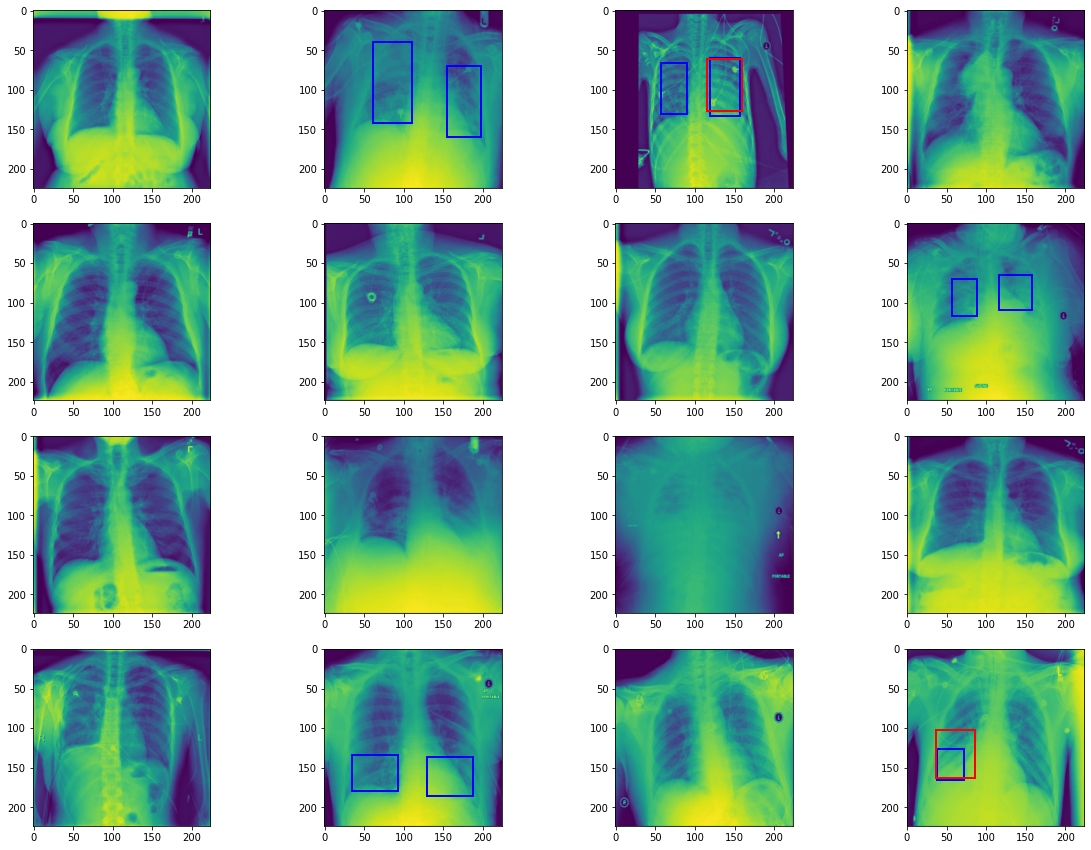

In [ ]:
for imgs, msks in valid_gen_simple:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 4, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [ ]:
folder = '/content/drive/MyDrive/Capstone/stage_2_test_images'
test_filenames = os.listdir(folder)
print('Number of test samples is', len(test_filenames))

Number of test samples is 3000


In [ ]:
test_gen = generator_single_channel(folder, test_filenames, None, batch_size=20, image_size=224, shuffle=False, predict=True)

In [ ]:
from skimage import measure
from skimage.transform import resize

In [ ]:
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission_test.csv')

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Capstone/submission_test.csv')

In [ ]:
bla = submission['PredictionString'][13:14]

In [ ]:
bla2 = np.array(bla)

In [ ]:
bla2

array(['0.849274 570 242 280 478 0.7001767 217 481 156 259 '],
      dtype=object)